# AutoLog Question-Answering Agent
This notebook implements a LangGraph agent that answers questions about vehicle ownership, costs, and maintenance based on the vehicles.json data.

## 1. Setup and Imports

In [15]:
from dotenv import load_dotenv
from typing import List, Any, Optional, Annotated, TypedDict
from datetime import datetime, date
import json
import os
import gradio

from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage, BaseMessage
from langchain_core.tools import BaseTool, StructuredTool
from langsmith import uuid7
from langchain_community.tools import Tool
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from IPython.display import Image
import sqlite3

load_dotenv(override=True)

True

## 2. Load Vehicle Data

In [16]:
# Load vehicles.json
with open('vehicles.json', 'r') as f:
    vehicles_data = json.load(f)

print(f"Loaded {len(vehicles_data)} vehicles")
print(f"\nVehicle keys: {list(vehicles_data.keys())[:3]}...")

# Display sample vehicle
first_vehicle = list(vehicles_data.values())[0]
print(f"\nSample vehicle structure:")
print(f"  Make/Model: {first_vehicle['year']} {first_vehicle['make']} {first_vehicle['model']}")
print(f"  Cost categories: {[k for k in first_vehicle.keys() if isinstance(first_vehicle[k], list)]}")

Loaded 27 vehicles

Vehicle keys: ['vehicle_1 ', 'vehicle_2', 'vehicle_3']...

Sample vehicle structure:
  Make/Model: 1988 Ford Bronco II
  Cost categories: ['insurance', 'registration', 'gas']


## 3. Define Data Analysis Tools

In [ ]:
def get_analysis_tools() -> List[BaseTool]:
    """Create tools for analyzing vehicle data."""
    
    def calculate_total_cost(vehicle_key: str, category: str = "all", start_date: str = "", end_date: str = "") -> str:
        """Calculate total cost for a vehicle by category and optional date range.
        Categories: insurance, registration, repairs, fuel, miscellaneous, all
        Dates in format: YYYY-MM-DD
        """
        if vehicle_key not in vehicles_data:
            return f"Error: Vehicle '{vehicle_key}' not found. Available: {list(vehicles_data.keys())[:5]}"
        
        vehicle = vehicles_data[vehicle_key]
        categories = [category] if category != "all" else ["insurance", "registration", "repairs", "fuel", "miscellaneous"]
        
        start = datetime.strptime(start_date, "%Y-%m-%d") if start_date else None
        end = datetime.strptime(end_date, "%Y-%m-%d") if end_date else None
        
        total = 0.0
        count = 0
        results = {}
        
        for cat in categories:
            if cat in vehicle and isinstance(vehicle[cat], list):
                cat_total = 0.0
                cat_count = 0
                for transaction in vehicle[cat]:
                    trans_date = datetime.strptime(transaction["date"], "%Y-%m-%d")
                    if (start is None or trans_date >= start) and (end is None or trans_date <= end):
                        cat_total += transaction.get("cost", 0)
                        cat_count += 1
                if cat_count > 0:
                    results[cat] = {"total": cat_total, "count": cat_count, "average": cat_total / cat_count}
                    total += cat_total
                    count += cat_count
        
        response = f"\nVehicle: {vehicle['year']} {vehicle['make']} {vehicle['model']}\n"
        for cat, data in results.items():
            response += f"{cat.capitalize()}: ${data['total']:.2f} ({data['count']} transactions, avg ${data['average']:.2f})\n"
        response += f"\nTotal: ${total:.2f} across {count} transactions"
        return response
    
    def get_vehicle_info(vehicle_key: str) -> str:
        """Get detailed information about a specific vehicle."""
        if vehicle_key not in vehicles_data:
            return f"Error: Vehicle '{vehicle_key}' not found."
        
        v = vehicles_data[vehicle_key]
        sold_date = v.get('soldDate')
        sold_price = v.get('soldPrice')
        sold_odometer = v.get('soldOdometer')
        
        # Build ownership section based on whether vehicle is sold or still owned
        if sold_date is None or sold_date == "":
            ownership_info = f"""
Ownership:
  Purchased: {v['purchasedDate']} for ${v['purchasedPrice']:.2f}
  Odometer at purchase: {v['purchasedOdometer']} miles
  Purchased from: {v['dealerName']}
  
  Status: Currently owned (not sold)"""
        else:
            ownership_info = f"""
Ownership:
  Purchased: {v['purchasedDate']} for ${v['purchasedPrice']:.2f}
  Odometer at purchase: {v['purchasedOdometer']} miles
  Purchased from: {v['dealerName']}
  
  Sold: {sold_date} for ${sold_price:.2f}
  Odometer at sale: {sold_odometer} miles"""
        
        info = f"""
Vehicle Information:
  Year/Make/Model: {v['year']} {v['make']} {v['model']}
  Color: {v['color']}
  VIN: {v['vinNumber']}
  License Plate: {v['licensePlateNumber']}
  {ownership_info}
  
Cost Summary:
  Insurance entries: {len(v.get('insurance', []))}
  Registration entries: {len(v.get('registration', []))}
  Repair entries: {len(v.get('repairs', []))}
  Fuel entries: {len(v.get('fuel', []))}
  Miscellaneous entries: {len(v.get('miscellaneous', []))}
        """
        return info
    
    def fuel_analysis(vehicle_key: str) -> str:
        """Analyze fuel costs and consumption for a vehicle."""
        if vehicle_key not in vehicles_data:
            return f"Error: Vehicle '{vehicle_key}' not found."
        
        vehicle = vehicles_data[vehicle_key]
        fuel_data = vehicle.get('fuel', [])
        
        if not fuel_data:
            return f"No fuel data available for this vehicle."
        
        total_cost = sum(f.get('cost', 0) for f in fuel_data)
        total_gallons = sum(f.get('gallons', 0) for f in fuel_data)
        entries = len(fuel_data)
        
        result = f"""
Fuel Analysis for {vehicle['year']} {vehicle['make']} {vehicle['model']}:
  Total fuel entries: {entries}
  Total cost: ${total_cost:.2f}
  Total gallons: {total_gallons:.2f}
  Cost per gallon: ${total_cost/total_gallons:.2f if total_gallons > 0 else 0}
  Average cost per fill-up: ${total_cost/entries:.2f}
        """
        
        # Calculate MPG if odometer data available
        sold_odometer = vehicle.get('soldOdometer')
        purchased_odometer = vehicle.get('purchasedOdometer')
        if sold_odometer is not None and purchased_odometer is not None:
            miles_driven = sold_odometer - purchased_odometer
            if miles_driven > 0 and total_gallons > 0:
                mpg = miles_driven / total_gallons
                cost_per_mile = total_cost / miles_driven
                result += f"  Miles driven: {miles_driven}\n"
                result += f"  Average MPG: {mpg:.2f}\n"
                result += f"  Cost per mile: ${cost_per_mile:.4f}\n"
        
        return result
    
    def cost_comparison() -> str:
        """Compare total costs across all vehicles."""
        comparison = "\nCost Comparison Across All Vehicles:\n"
        comparison += "-" * 80 + "\n"
        comparison += f"{'Vehicle':<30} {'Total Cost':>15} {'Months Owned':>15} {'Cost/Month':>15}\n"
        comparison += "-" * 80 + "\n"
        
        vehicles_list = []
        
        for vkey, vehicle in vehicles_data.items():
            total = 0.0
            for cat in ['insurance', 'registration', 'repairs', 'fuel', 'miscellaneous']:
                total += sum(t.get('cost', 0) for t in vehicle.get(cat, []))
            
            purchase = datetime.strptime(vehicle['purchasedDate'], "%Y-%m-%d")
            sold_date = vehicle.get('soldDate')
            
            # Handle vehicles that haven't been sold yet
            if sold_date is None or sold_date == "":
                # Use today's date as the end date for unsold vehicles
                sold = datetime.now()
                status_suffix = " (current)"
            else:
                sold = datetime.strptime(sold_date, "%Y-%m-%d")
                status_suffix = ""
            
            months = (sold - purchase).days / 30.0
            
            vehicles_list.append({
                'name': f"{vehicle['year']} {vehicle['make']} {vehicle['model']}{status_suffix}",
                'total': total,
                'months': months,
                'monthly': total / months if months > 0 else 0
            })
        
        vehicles_list.sort(key=lambda x: x['total'], reverse=True)
        
        for v in vehicles_list:
            comparison += f"{v['name']:<30} ${v['total']:>14,.2f} {v['months']:>15.1f} ${v['monthly']:>14,.2f}\n"
        
        return comparison
    
    def most_driven_vehicle() -> str:
        """Find which vehicle was driven the most (highest odometer difference)."""
        vehicles_list = []
        
        for vkey, vehicle in vehicles_data.items():
            sold_odometer = vehicle.get('soldOdometer')
            purchased_odometer = vehicle.get('purchasedOdometer')
            
            # Only include vehicles with complete odometer data
            if sold_odometer is not None and purchased_odometer is not None:
                miles_driven = sold_odometer - purchased_odometer
                vehicles_list.append({
                    'key': vkey,
                    'name': f"{vehicle['year']} {vehicle['make']} {vehicle['model']}",
                    'color': vehicle['color'],
                    'miles': miles_driven,
                    'purchased': vehicle['purchasedDate'],
                    'sold': vehicle.get('soldDate', 'Still owned')
                })
        
        if not vehicles_list:
            return "No vehicles with complete odometer data found."
        
        # Sort by miles driven
        vehicles_list.sort(key=lambda x: x['miles'], reverse=True)
        
        result = "\nVehicles Ranked by Miles Driven:\n"
        result += "-" * 80 + "\n"
        result += f"{'Vehicle':<35} {'Miles Driven':>15} {'Owned':>25}\n"
        result += "-" * 80 + "\n"
        
        for i, v in enumerate(vehicles_list[:10], 1):  # Top 10
            ownership_period = f"{v['purchased']} to {v['sold']}"
            result += f"{v['name']:<35} {v['miles']:>15,} {ownership_period:>25}\n"
        
        most_driven = vehicles_list[0]
        result += f"\n✓ Most driven: {most_driven['name']} ({most_driven['color']}) with {most_driven['miles']:,} miles"
        
        return result
    
    def search_vehicles(year: str = "", make: str = "", model: str = "", color: str = "") -> str:
        """Search for vehicles matching criteria."""
        results = []
        
        for vkey, vehicle in vehicles_data.items():
            match = True
            if year and str(vehicle.get('year', '')) != year:
                match = False
            if make and vehicle.get('make', '').lower() != make.lower():
                match = False
            if model and vehicle.get('model', '').lower() != model.lower():
                match = False
            if color and vehicle.get('color', '').lower() != color.lower():
                match = False
            
            if match:
                results.append({
                    'key': vkey,
                    'name': f"{vehicle['year']} {vehicle['make']} {vehicle['model']}",
                    'color': vehicle['color']
                })
        
        if not results:
            return f"No vehicles found matching: year={year}, make={make}, model={model}, color={color}"
        
        response = f"Found {len(results)} vehicle(s):\n"
        for v in results:
            response += f"  - {v['name']} ({v['color']}) - Key: {v['key']}\n"
        
        return response
    
    # Create tools
    tools = [
        StructuredTool.from_function(
            func=calculate_total_cost,
            name="calculate_total_cost",
            description="Calculate total cost for a vehicle by category (insurance, registration, repairs, fuel, miscellaneous, or all). Optionally filter by date range."
        ),
        StructuredTool.from_function(
            func=get_vehicle_info,
            name="get_vehicle_info",
            description="Get detailed information about a specific vehicle including purchase/sale details and cost entry counts."
        ),
        StructuredTool.from_function(
            func=fuel_analysis,
            name="fuel_analysis",
            description="Analyze fuel costs and consumption for a vehicle, including MPG and cost per mile."
        ),
        StructuredTool.from_function(
            func=cost_comparison,
            name="cost_comparison",
            description="Compare total costs across all vehicles. No parameters needed."
        ),
        StructuredTool.from_function(
            func=most_driven_vehicle,
            name="most_driven_vehicle",
            description="Find which vehicle was driven the most (highest miles driven). No parameters needed."
        ),
        StructuredTool.from_function(
            func=search_vehicles,
            name="search_vehicles",
            description="Search for vehicles by year, make, model, or color."
        ),
    ]
    
    return tools

tools = get_analysis_tools()
print(f"Created {len(tools)} analysis tools")

## 4. Setup Memory and State

In [18]:
# Setup SQLite for memory
db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

# Define state
class State(TypedDict):
    messages: Annotated[List[Any], add_messages]

graph_builder = StateGraph(State)
print("Memory and state initialized")

Memory and state initialized


## 5. Define System Prompt and Agent

In [ ]:
qa_system_message = """
You are an AutoLog Question-Answering Agent. Your role is to help users understand their vehicle ownership history and associated costs.

You have access to a comprehensive vehicle database containing information about:
- Vehicle details (make, model, year, color, VIN, license plate)
- Purchase and sale information
- Cost tracking data (insurance, registration, repairs, fuel, miscellaneous)
- Odometer readings (purchase and sale)

Available tools allow you to:
1. Calculate total costs by category and date range
2. Get detailed vehicle information
3. Analyze fuel consumption and costs
4. Compare costs across all vehicles
5. Find the most driven vehicle (highest miles driven)
6. Search for vehicles by characteristics

IMPORTANT GUIDELINES:
- Use search_vehicles FIRST if you don't know the exact vehicle key. Once you find the key, use it in other tools.
- Do NOT call the same tool multiple times with similar parameters.
- If a tool returns a result, use that result to answer the question - do not call more tools.
- Complete the user's request as quickly as possible with the minimum number of tool calls.
- For currently owned vehicles (not sold), there will be no soldDate, soldPrice, or soldOdometer values.

When answering questions:
1. First understand what the user is asking
2. Use the appropriate tools to gather data (usually just 1-2 tool calls)
3. Analyze the results and provide clear, concise answers
4. Include relevant context (e.g., date ranges, comparisons)
5. Use formatting to make data easy to understand

If a user asks about a specific vehicle but you're not sure which one, use search_vehicles to find matches.
When asked about which vehicle was driven the most, use most_driven_vehicle.
Always provide specific numbers and context in your responses.
"""

## 6. Build LangGraph

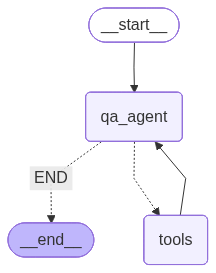

Graph compiled successfully!


In [20]:
# Create the QA agent
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def qa_agent(state: State):
    """Main QA agent node."""
    messages = []

    # Convert all messages to proper LangChain message objects
    for msg in state["messages"]:
        if isinstance(msg, dict):
            if msg["role"] == "system":
                messages.append(SystemMessage(content=msg["content"]))
            elif msg["role"] == "user":
                messages.append(HumanMessage(content=msg["content"]))
            elif msg["role"] == "assistant":
                # For assistant messages, preserve tool_calls if present
                content = msg.get("content", "")
                tool_calls = msg.get("tool_calls")
                # Only add tool_calls if they exist and are non-empty
                if tool_calls:
                    messages.append(AIMessage(content=content, tool_calls=tool_calls))
                else:
                    messages.append(AIMessage(content=content))
            elif msg["role"] == "tool":
                messages.append(ToolMessage(content=msg["content"], tool_call_id=msg.get("tool_call_id")))
        # Handle LangChain message objects directly
        else:
            messages.append(msg)

    # Ensure system message is present at the beginning
    has_system_message = any(isinstance(m, SystemMessage) for m in messages)
    if not has_system_message:
        messages.insert(0, SystemMessage(content=qa_system_message))

    # Debug: Print message types before sending to LLM
    print(f"[QA Agent] Sending {len(messages)} messages to LLM:")
    for i, msg in enumerate(messages):
        msg_type = type(msg).__name__
        if isinstance(msg, AIMessage):
            has_tools = f"with {len(msg.tool_calls)} tool_calls" if msg.tool_calls else "no tool_calls"
            print(f"  {i}: {msg_type} {has_tools}")
        elif isinstance(msg, ToolMessage):
            print(f"  {i}: {msg_type} (tool_call_id={msg.tool_call_id})")
        else:
            print(f"  {i}: {msg_type}")

    response = llm_with_tools.invoke(messages)
    print(f"[QA Agent] LLM response type: {type(response).__name__}")
    if hasattr(response, 'tool_calls') and response.tool_calls:
        print(f"[QA Agent] Tool calls: {len(response.tool_calls)}")

    return {"messages": [response]}

# Add nodes
graph_builder.add_node("qa_agent", qa_agent)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Define routing
def route_agent(state: State):
    """Route based on whether agent calls tools."""
    last_message = state["messages"][-1]
    print(f"[Router] Last message type: {type(last_message).__name__}")
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        print(f"[Router] Routing to tools")
        return "tools"
    print(f"[Router] Routing to END")
    return "END"

# Add edges
graph_builder.add_edge(START, "qa_agent")
graph_builder.add_conditional_edges(
    "qa_agent",
    route_agent,
    {"tools": "tools", "END": END}
)
graph_builder.add_edge("tools", "qa_agent")

# Compile with increased recursion limit
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))
print("Graph compiled successfully!")

## 7. Test with Gradio Interface

In [ ]:
config = {"configurable": {"thread_id": uuid7()}}

with gradio.Blocks() as demo:
    chatbot = gradio.Chatbot(type="messages")
    user_input_box = gradio.Textbox(label="Ask about your vehicles...")
    submit_btn = gradio.Button("Send")

    def chat_handler(message, history):
        # Invoke the graph with a reasonable recursion limit
        # This prevents infinite loops while allowing multi-step reasoning
        result = graph.invoke(
            {"messages": [{"role": "user", "content": message}]}, 
            config={**config, "recursion_limit": 25}
        )
        last_message = result["messages"][-1]

        # Convert to proper format for Gradio
        # Only convert non-ToolMessage objects for display
        if isinstance(last_message, ToolMessage):
            # Skip tool messages in UI - they're internal implementation details
            # Find the last non-tool message instead
            for msg in reversed(result["messages"]):
                if not isinstance(msg, ToolMessage):
                    last_message = msg
                    break
        
        # Build assistant message dict
        if isinstance(last_message, str):
            assistant_message = {"role": "assistant", "content": last_message}
        elif isinstance(last_message, dict):
            assistant_message = last_message
        elif isinstance(last_message, AIMessage):
            # Extract content, ignore tool_calls for UI display
            assistant_message = {"role": "assistant", "content": last_message.content or ""}
        elif hasattr(last_message, 'content'):
            assistant_message = {"role": "assistant", "content": last_message.content}
        else:
            assistant_message = {"role": "assistant", "content": str(last_message)}

        return history + [{"role": "user", "content": message}, assistant_message]

    submit_btn.click(chat_handler, [user_input_box, chatbot], chatbot)

demo.launch()